# Stock Market Prediction Project

In [1]:
import numpy as np
import pandas as pd
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (20,10)

data = pd.read_csv("data.csv", parse_dates=["date"], index_col="date")
x = pd.DataFrame(data)
x.head(10)

,signal,spy_close_price
date,,
2012-01-03,3.107767,127.495
2012-01-04,3.107282,127.700
2012-01-05,3.099757,128.040
2012-01-06,3.134223,127.710
2012-01-09,3.135922,128.020
2012-01-10,3.143447,129.130
2012-01-11,3.127184,129.200
2012-01-12,3.139320,129.510
2012-01-13,3.174029,128.840


## CLEAN UP THE DATA

We clean the data by removing the outliers that exist in the data

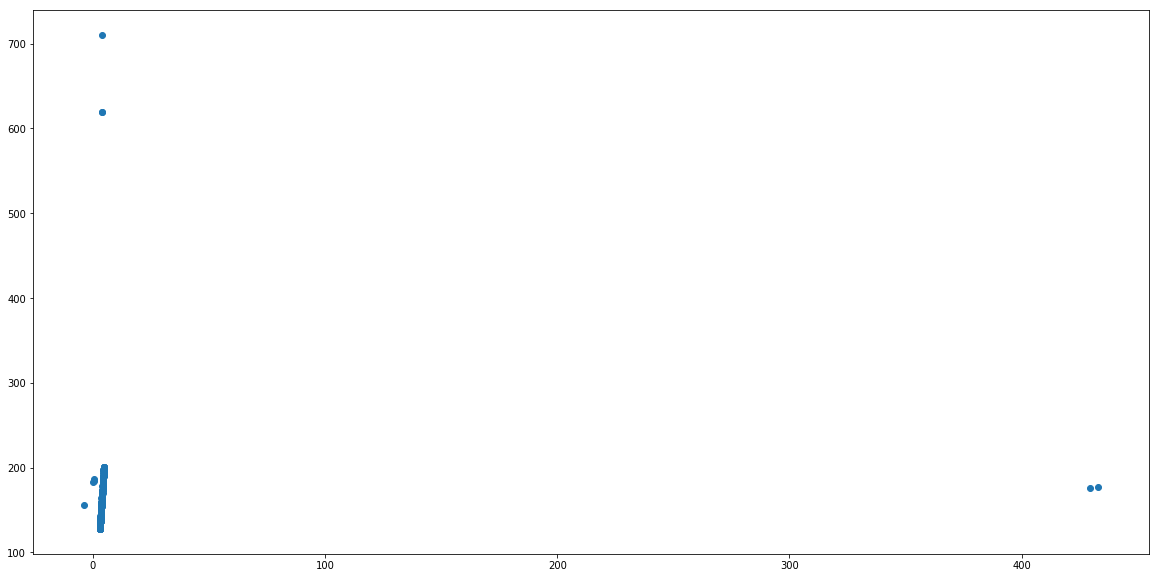

In [2]:
plt.scatter(x['signal'], x['spy_close_price'])
plt.show()

Clearing out obvious outlier data

In [3]:
linear_data = x
linear_data = linear_data[linear_data.loc[:,'spy_close_price'] < 300]
linear_data = linear_data[linear_data.loc[:,'signal'] < 100]
linear_data = linear_data[linear_data.loc[:,'signal'] > 2]

### We can now see that their is indeed a correlation between signal and close price

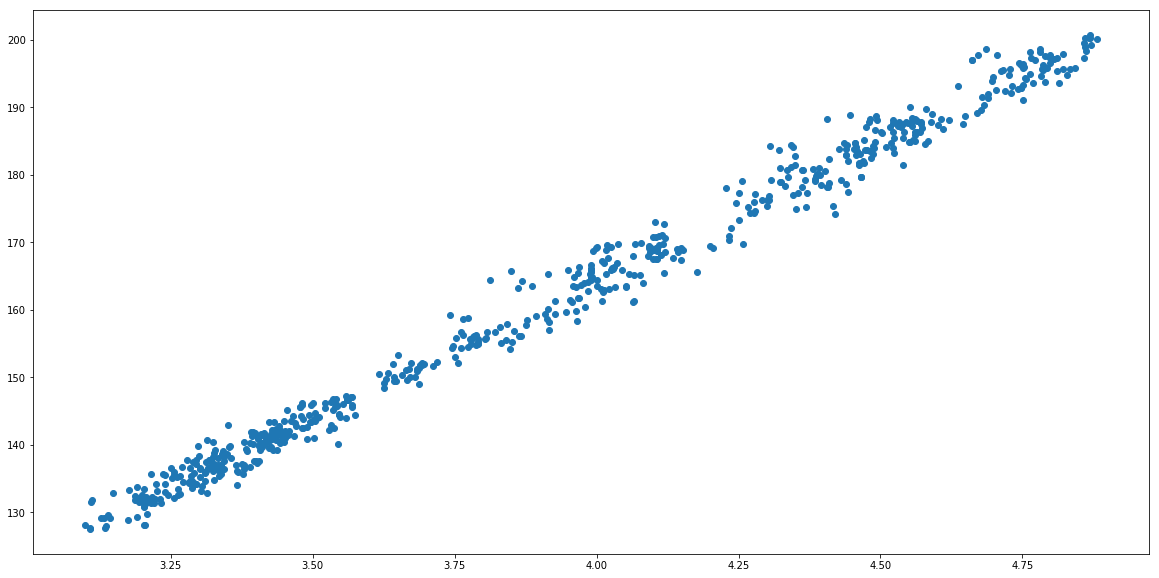

In [4]:
plt.scatter(linear_data['signal'], linear_data['spy_close_price'])
plt.show()

### After seeing the linear correlation, we can now model the data using Linear Regression.
### We then find the coefficient or slope of the line.
### The mean square error to see how well the line fits
$ MSE = \frac{1}{n} \sum_{i=1}^{n} (Y_i- \hat{Y_i})^2$
### Finally we find the R-Squared value to see how close the data fits the regression line

Coefficients: 
 [ 40.82405753]
Mean squared error: 4.54
R-squared = : 0.56


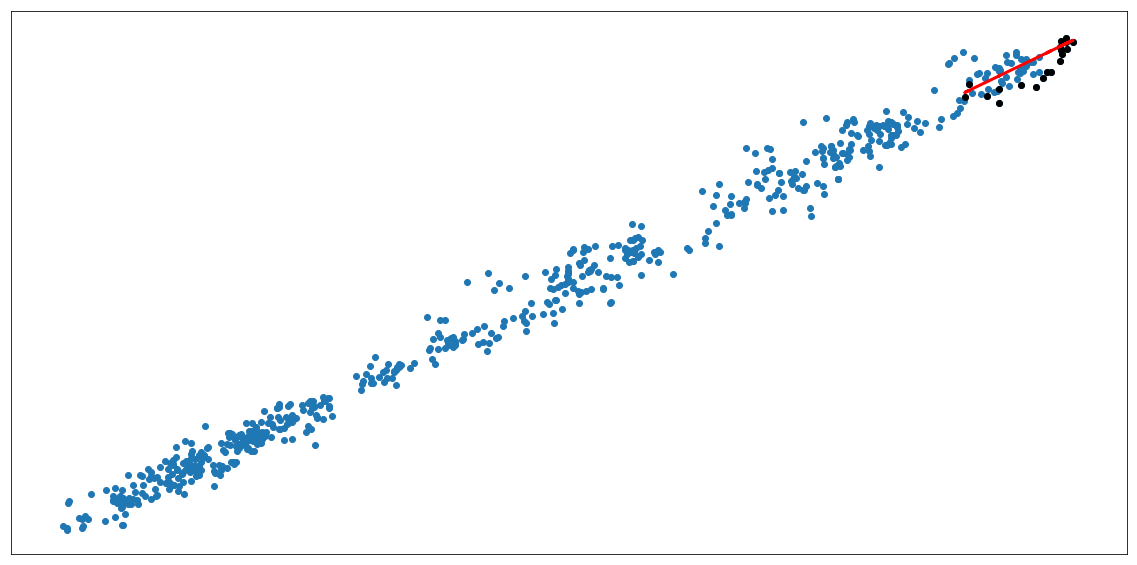

In [5]:
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score

# Split the data into training/testing sets
X_train = linear_data['signal'][:-20]
X_test = linear_data['signal'][-20:]

# Split the targets into training/testing sets
y_train = linear_data['spy_close_price'][:-20]
y_test = linear_data['spy_close_price'][-20:]

# Create linear regression object
regr = linear_model.LinearRegression()
X_train = X_train.values.reshape(-1, 1)
X_test = X_test.values.reshape(-1, 1)

# Train the model using the training sets
regr.fit(X_train, y_train)

# Make predictions using the testing set
y_pred = regr.predict(X_test)


# The coefficients
print('Coefficients: \n', regr.coef_)
# The mean squared error
print("Mean squared error: %.2f"
      % mean_squared_error(y_test, y_pred))
# Explained variance score: 1 is perfect prediction
print('R-squared = : %.2f' % r2_score(y_test, y_pred))

# Plot outputs
plt.scatter(linear_data['signal'], linear_data['spy_close_price'])
plt.scatter(X_test, y_test,  color='black')
plt.plot(X_test, y_pred, color='red', linewidth=3)

plt.xticks(())
plt.yticks(())

plt.show()

cleaning outlier data for the date to closing price relationship

In [6]:
df = x
df = df[df.loc[:,'spy_close_price'] < 300]
df = df[df.loc[:,'spy_close_price'] > 0]

plotting the relationship between date and closing price - comparing raw data with cleaned

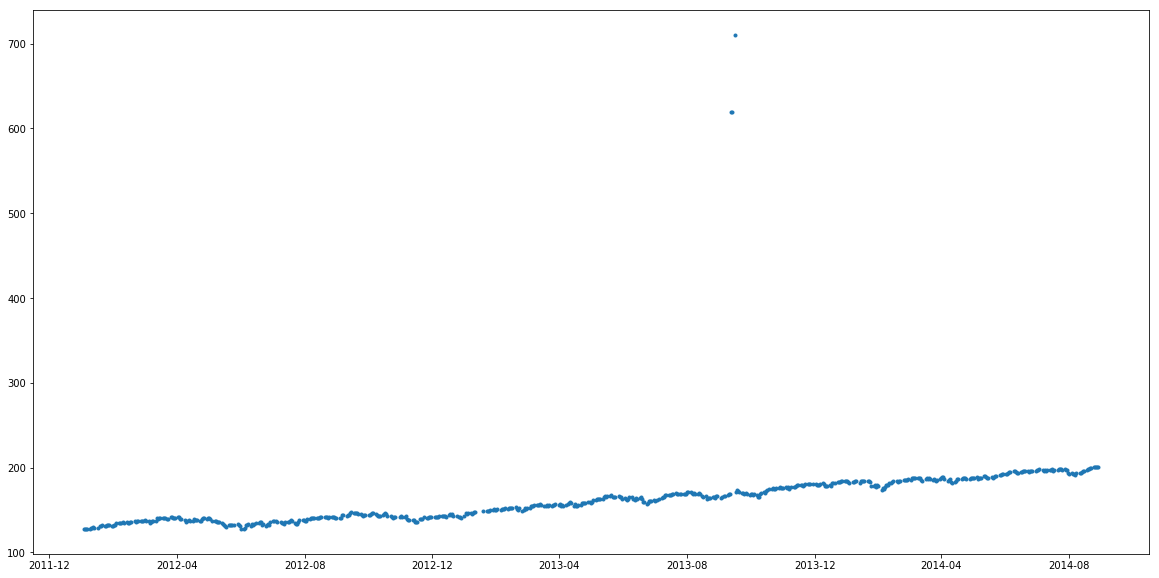

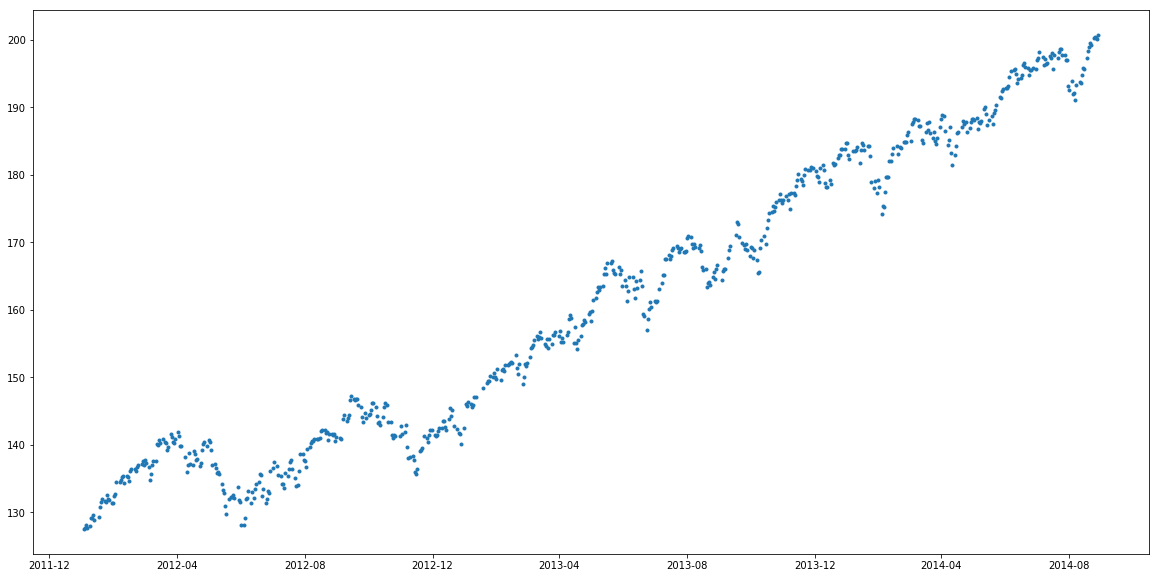

In [7]:
plt.plot(x.index.tolist(), x['spy_close_price'], '.')
plt.show()

plt.plot(df.index.tolist(), df['spy_close_price'], '.')
plt.show()

In [8]:
ts = df.drop(columns=['signal'])
ts.head()

,spy_close_price
date,
2012-01-03,127.495
2012-01-04,127.700
2012-01-05,128.040
2012-01-06,127.710
2012-01-09,128.020


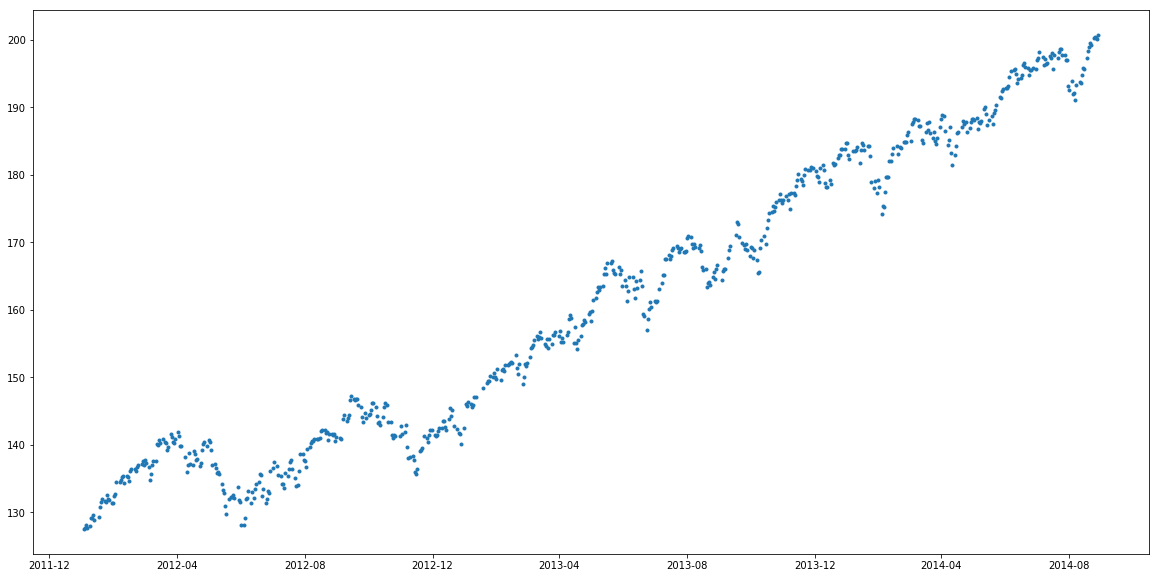

In [9]:
plt.plot(ts, '.')
plt.show()

## SOME COMPUTATION
Back to checking stationarity, we’ll be using the rolling statistics plots along with Dickey-Fuller test results, so we defined a function which take a TS as input and generated them for us.

In [10]:
#citation: https://www.analyticsvidhya.com/blog/2016/02/time-series-forecasting-codes-python/
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries):
    
    #Determing rolling statistics
    rolmean = pd.rolling_mean(timeseries, window=12)
    rolstd = pd.rolling_std(timeseries, window=12)

    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey-Fuller test:
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

/Users/arkwl/anaconda3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


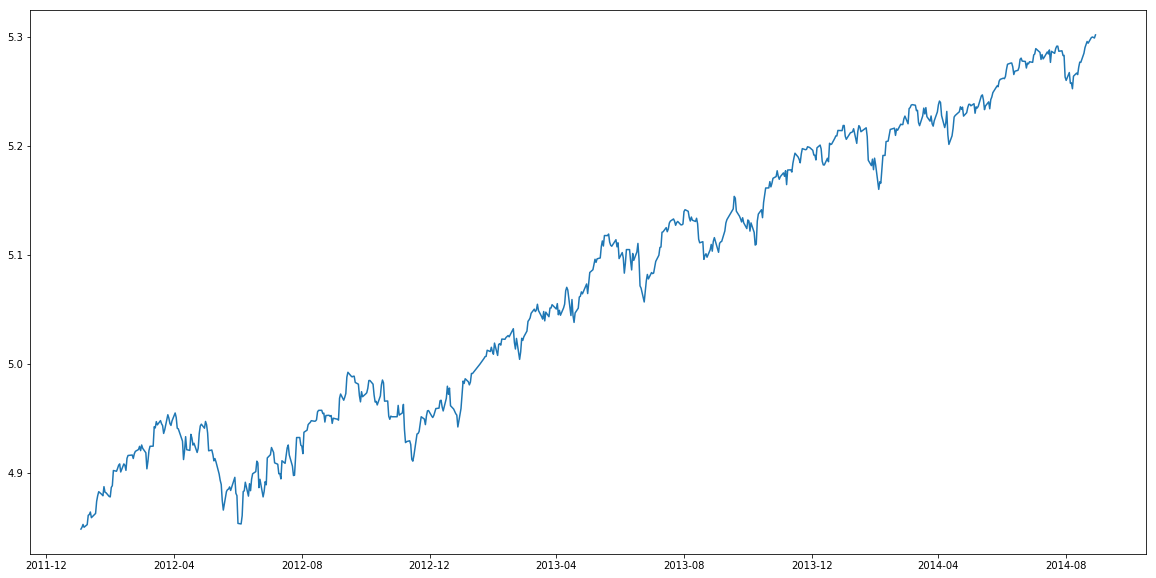

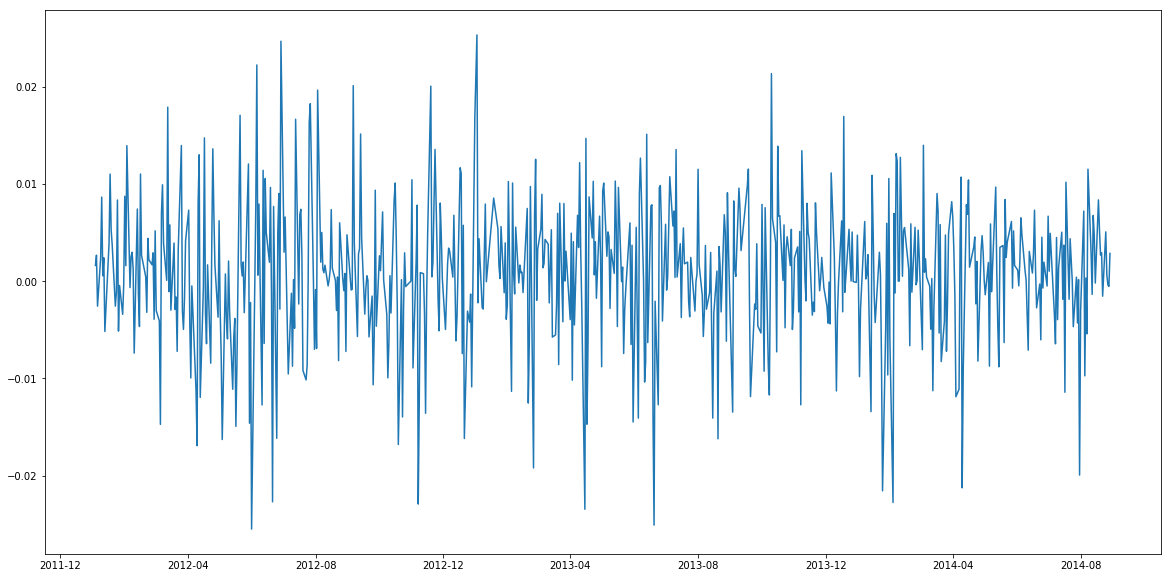

In [11]:
ts_log = np.log(ts)
plt.plot(ts_log)
plt.show()

ts_log_diff = ts_log - ts_log.shift()
plt.plot(ts_log_diff)
plt.show()

In [40]:
#test_stationarity(ts_log_diff)

## FORCASTING TIME SERIES
### We use the autocorrelation function to find a pattern between the prices seperated by certain time periods.

To use ARIMA effectively, we need to determine the parameters of the model, the number of auto regressive terms, the number of moving average terms, and the number of differences.

We use the following two plot to determine the number of auto regressive terms, the number of moving average terms.

In [13]:
from statsmodels.tsa.stattools import acf, pacf

ts_log_diff.dropna(inplace=True)

lag_acf = acf(ts_log_diff, nlags=20)
lag_pacf = pacf(ts_log_diff, nlags=20, method='ols')

ACF is a measure of the correlation between the the TS with a lagged version of itself. 

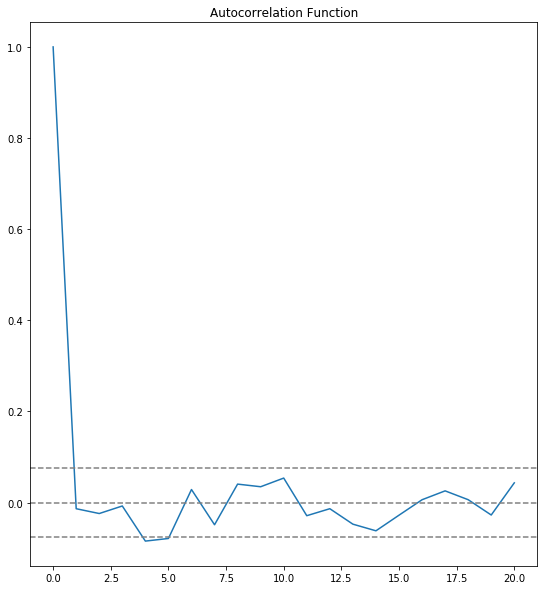

In [14]:
#Plot ACF: 
plt.subplot(121) 
plt.plot(lag_acf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.title('Autocorrelation Function')
plt.show()

MA terms are lagged forecast errors in prediction equation.

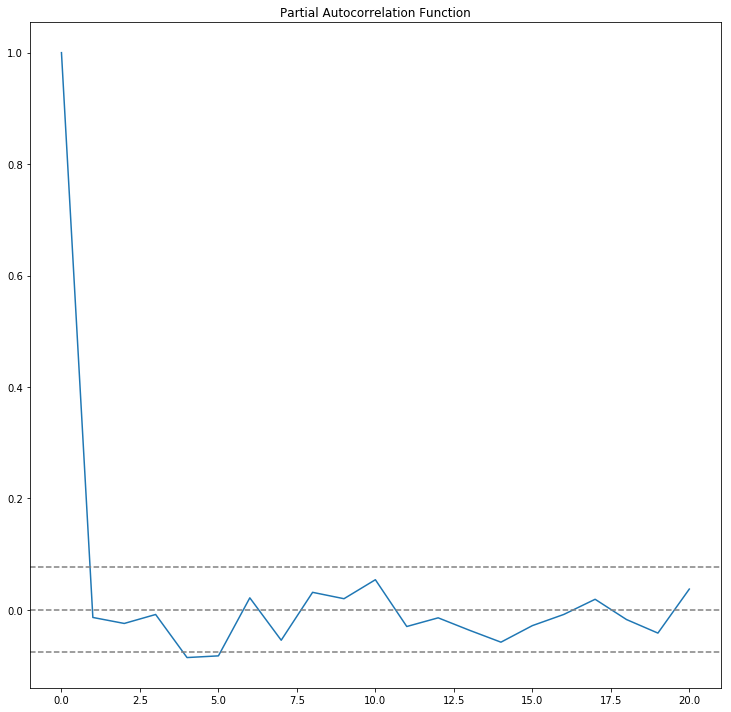

In [15]:
#Plot PACF:
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.title('Partial Autocorrelation Function')
plt.tight_layout()
plt.show()

In [16]:
ts_log_diff.head()

,spy_close_price
date,
2012-01-04,0.001607
2012-01-05,0.002659
2012-01-06,-0.002581
2012-01-09,0.002424
2012-01-10,0.008633


### Auto Regressive Model

In [17]:
from statsmodels.tsa.arima_model import ARIMA

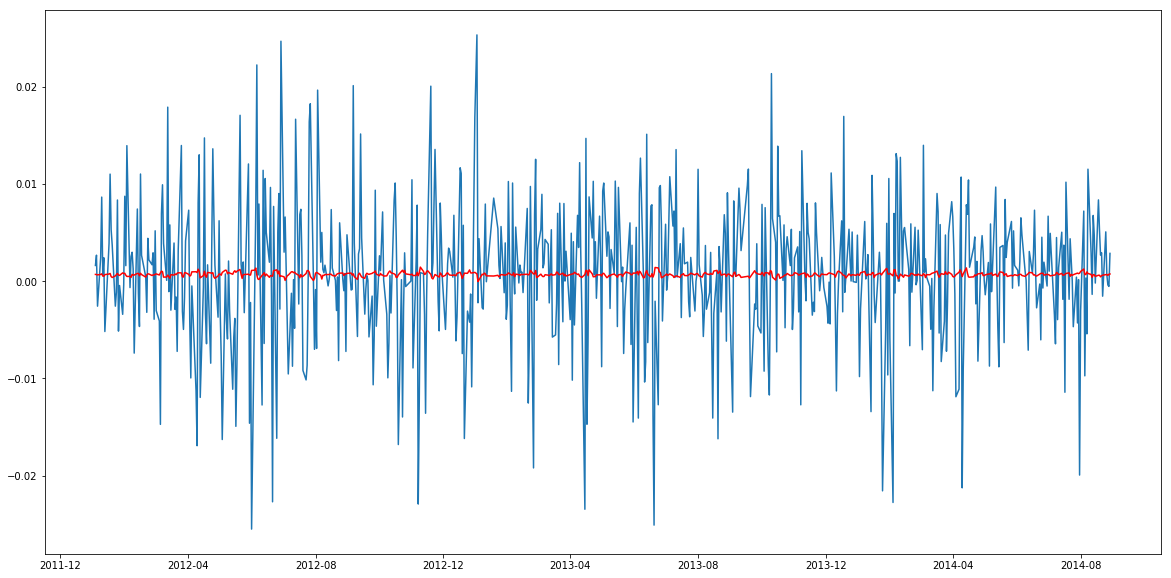

In [18]:
model = ARIMA(ts_log, order=(2, 1, 0))  
results_AR = model.fit(disp=-1)  
plt.plot(ts_log_diff)
plt.plot(results_AR.fittedvalues, color='red')
plt.show()

### Moving Average Model

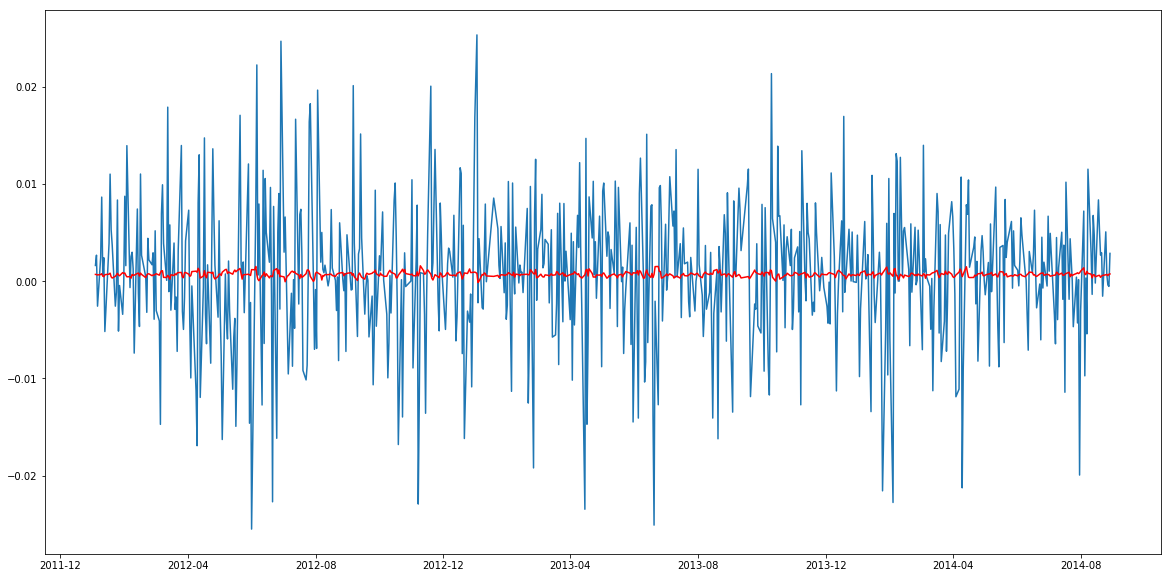

In [19]:
model = ARIMA(ts_log, order=(0, 1, 2))  
results_MA = model.fit(disp=-1)  
plt.plot(ts_log_diff)
plt.plot(results_MA.fittedvalues, color='red')
plt.show()

### Combined Model

/Users/arkwl/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


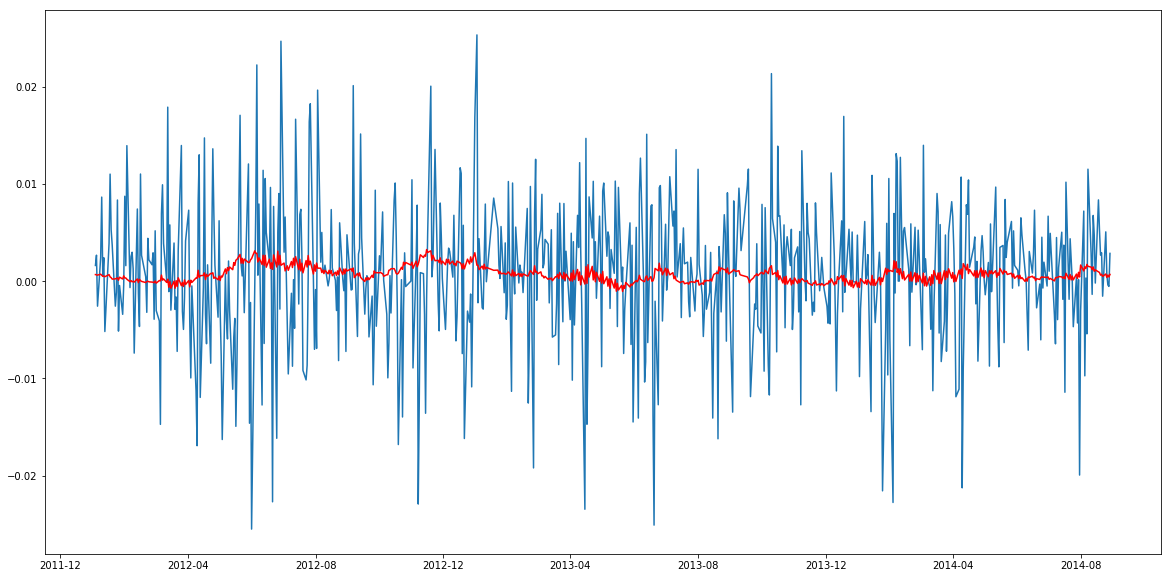

In [20]:

model = ARIMA(ts_log, order=(2, 1, 2))  
results_ARIMA = model.fit(disp=-1)  
plt.plot(ts_log_diff)
plt.plot(results_ARIMA.fittedvalues, color='red')
plt.show()

In [21]:
predictions_ARIMA_diff = pd.Series(results_ARIMA.fittedvalues, copy=True)
print(predictions_ARIMA_diff.head())

date
2012-01-04    0.000667
2012-01-05    0.000644
2012-01-06    0.000609
2012-01-09    0.000708
2012-01-10    0.000597
dtype: float64


## The following calculations will turn the trend taken from the combined model, and change the scale back to the original values
This step stores the predicted results as a seperate series.

In [22]:
predictions_ARIMA_diff_cumsum = predictions_ARIMA_diff.cumsum()
print (predictions_ARIMA_diff_cumsum.head())

date
2012-01-04    0.000667
2012-01-05    0.001311
2012-01-06    0.001920
2012-01-09    0.002629
2012-01-10    0.003226
dtype: float64


Then add the cumulative sum

In [23]:
predictions_ARIMA_log = pd.Series(ts_log.iloc[0][0], index=ts_log.index)
predictions_ARIMA_log = predictions_ARIMA_log.add(predictions_ARIMA_diff_cumsum,fill_value=0)
predictions_ARIMA_log.head()

date
2012-01-03    4.848077
2012-01-04    4.848744
2012-01-05    4.849388
2012-01-06    4.849997
2012-01-09    4.850706
dtype: float64

### Observe the forcast of the stock data

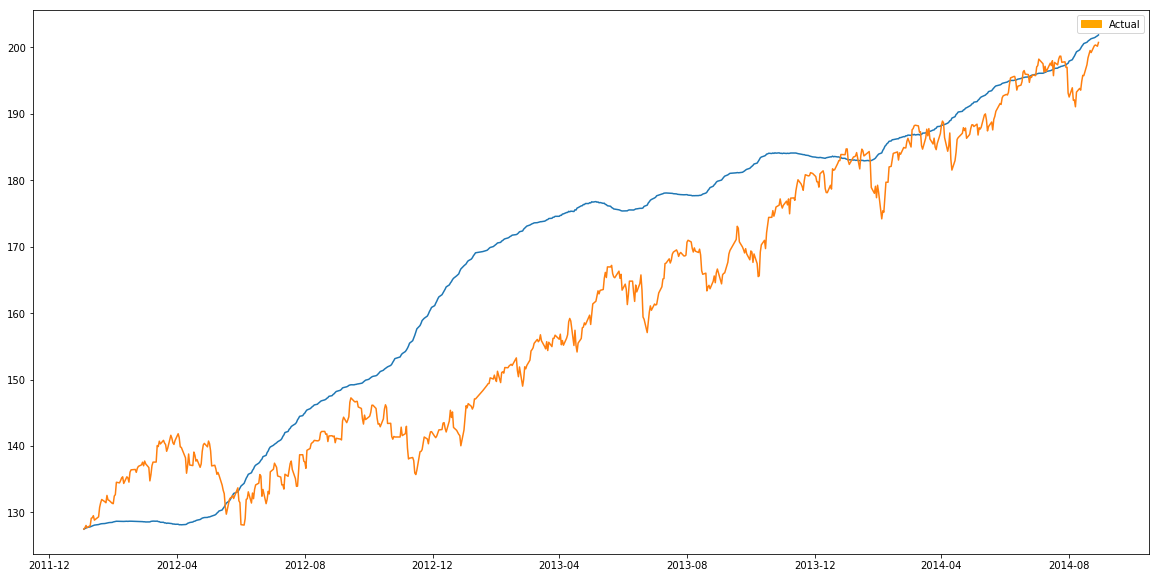

In [24]:
predictions_ARIMA = np.exp(predictions_ARIMA_log)
plt.plot(predictions_ARIMA)
#plt.show()
plt.plot(ts)
blue_patch = mpatches.Patch(color='blue', label='Prediction')
plt.legend(handles=[blue_patch])
orange_patch = mpatches.Patch(color='orange', label='Actual')
plt.legend(handles=[orange_patch])
plt.show()

# Here we start setting the data up to be used in a neural network create a model that can predict the stock prices

In [25]:
ts = ts.sort_index(axis=1, ascending=True)
ts = ts.iloc[::-1]

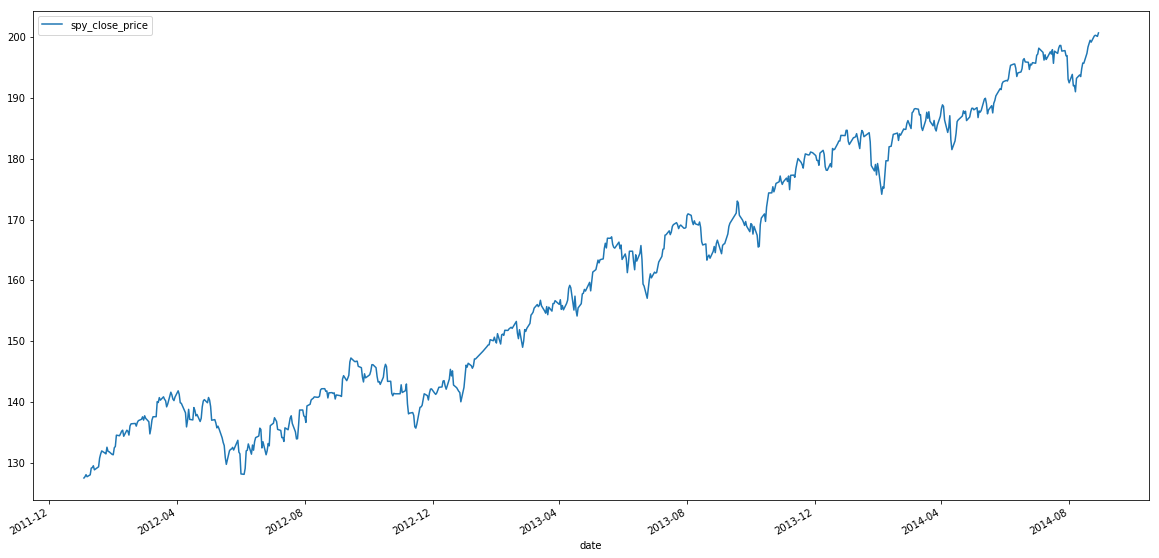

In [26]:
data = ts[['spy_close_price']]
data.plot(y='spy_close_price')
plt.show()

Split the data into train and test

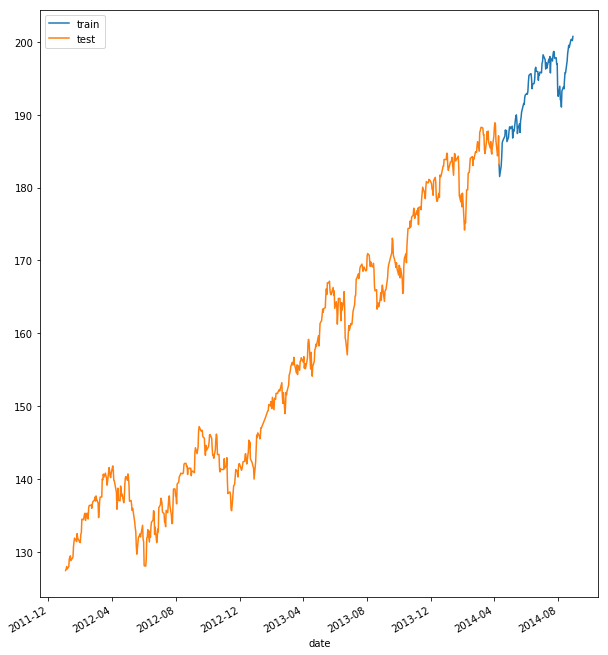

In [27]:
split_date = pd.Timestamp('04-10-2014')

train = data.loc[:split_date]
test = data.loc[split_date:]

ax = train.plot(figsize=(10,12))
test.plot(ax=ax)
plt.legend(['train', 'test'])
plt.show()

### The next few cells transfom the date to a float and create X_test, y_test, X_train and y_train


### X - the input - contains dates
### y - the output - contains stock prices

In [28]:
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler()
train_sc = sc.fit_transform(train)
test_sc = sc.transform(test)

In [42]:
train_sc_df = pd.DataFrame(train_sc, columns=['Y'], index=train.index)
test_sc_df = pd.DataFrame(test_sc, columns=['Y'], index=test.index)

for s in range(1,2):
    train_sc_df['X_{}'.format(s)] = train_sc_df['Y'].shift(s)
    test_sc_df['X_{}'.format(s)] = test_sc_df['Y'].shift(s)

X_train = train_sc_df.dropna().drop('Y', axis=1)
y_train = train_sc_df.dropna().drop('X_1', axis=1)

X_test = test_sc_df.dropna().drop('Y', axis=1)
y_test = test_sc_df.dropna().drop('X_1', axis=1)

X_train = X_train.as_matrix()
y_train = y_train.as_matrix()

X_test = X_test.as_matrix()
y_test = y_test.as_matrix()

In [30]:
print('Train size: (%d x %d)'%(X_train.shape[0], X_train.shape[1]))
print('Test size: (%d x %d)'%(X_test.shape[0], X_test.shape[1]))

Train size: (98 x 1)
Test size: (565 x 1)


## Setup baseline model of SVM Regressor
SVM Regressor is a sklearn model we will use to predict y based off our X_test. It shows a great r^2 score below

In [31]:
from sklearn.svm import SVR
regressor = SVR(kernel='linear')

In [32]:
regressor.fit(X_train, y_train)
y_pred = regressor.predict(X_test)

/Users/arkwl/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


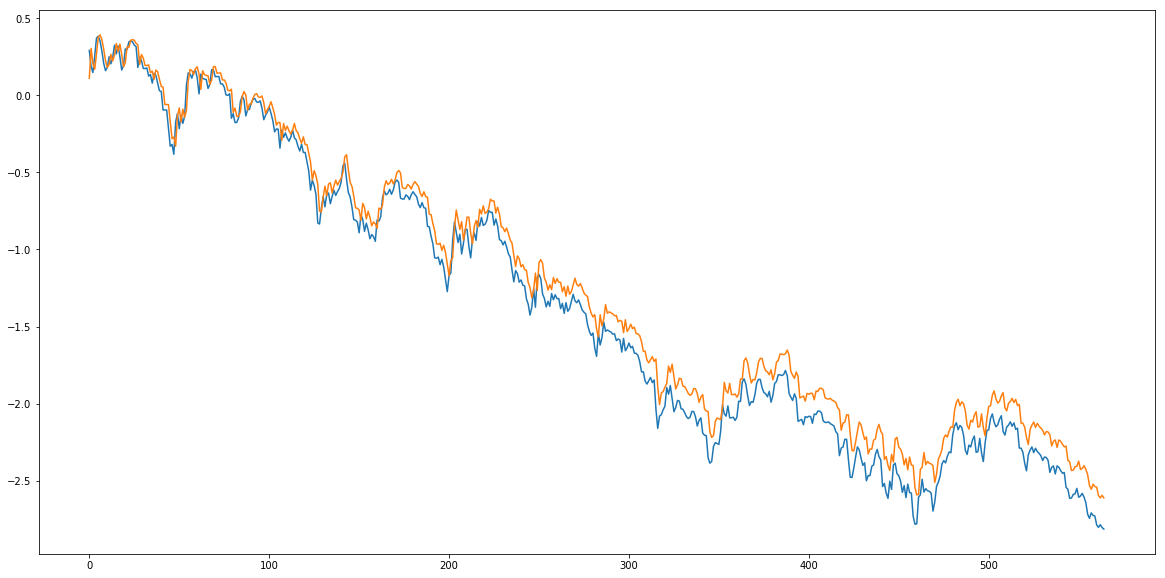

In [33]:
plt.plot(y_test)
plt.plot(y_pred)
plt.show()

In [34]:
from  sklearn.metrics import r2_score

def adj_r2_score(r2, n, k):
    return 1-((1-r2)*((n-1)/(n-k-1)))

r2_test = r2_score(y_test, y_pred)
print(r2_test)

0.97796018476


### Implementation of Tensorflow Neural Network

In [35]:
from  keras.models  import Sequential
from keras.layers import Dense
from keras.optimizers import Adam
import keras.backend as K

Using TensorFlow backend.


## 1 hidden layer with neuron

In [36]:
K.clear_session()
model = Sequential()
model.add(Dense(1, input_shape=(X_test.shape[1],), activation='tanh', kernel_initializer='lecun_uniform'))
model.compile(optimizer=Adam(lr=0.001), loss='mean_squared_error')
model.fit(X_train, y_train, batch_size=16, epochs=20, verbose=1)

Epoch 1/20
98/98 [==============================] - 0s 857us/step - loss: 0.0246
Epoch 2/20
98/98 [==============================] - 0s 122us/step - loss: 0.0227
Epoch 3/20
98/98 [==============================] - 0s 79us/step - loss: 0.0209
Epoch 4/20
98/98 [==============================] - 0s 83us/step - loss: 0.0193
Epoch 5/20
98/98 [==============================] - 0s 125us/step - loss: 0.0179
Epoch 6/20
98/98 [==============================] - 0s 101us/step - loss: 0.0166
Epoch 7/20
98/98 [==============================] - 0s 82us/step - loss: 0.0156
Epoch 8/20
98/98 [==============================] - 0s 107us/step - loss: 0.0147
Epoch 9/20
98/98 [==============================] - 0s 136us/step - loss: 0.0138
Epoch 10/20
98/98 [==============================] - 0s 74us/step - loss: 0.0131
Epoch 11/20
98/98 [==============================] - 0s 96us/step - loss: 0.0125
Epoch 12/20
98/98 [==============================] - 0s 157us/step - loss: 0.0120
Epoch 13/20
98/98 [===========

R-Squared: 0.054026


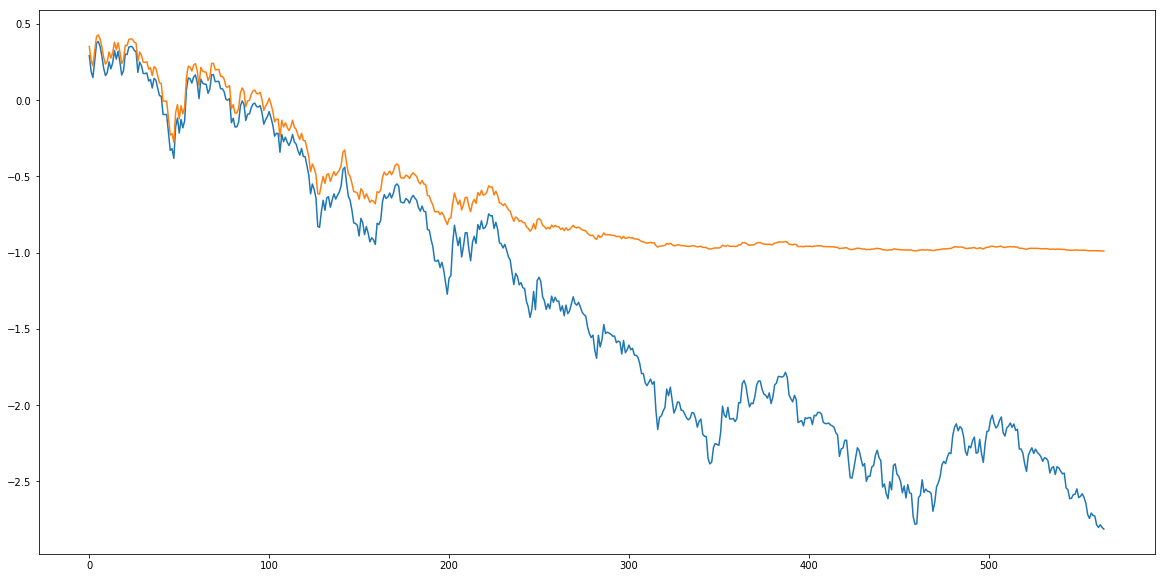

In [37]:
y_pred = model.predict(y_test)
plt.plot(y_test)
plt.plot(y_pred)
print('R-Squared: %f'%(r2_score(y_test, y_pred)))
plt.show()

### 1 Hidden Layer with 2 neurons and ReLU activation function


In [38]:
K.clear_session()
model = Sequential()
model.add(Dense(2, input_shape=(X_test.shape[1],), activation='relu', kernel_initializer='lecun_uniform'))
model.add(Dense(1))
model.compile(optimizer=Adam(lr=0.001), loss='mean_squared_error')
model.fit(X_train, y_train, batch_size=16, epochs=20, verbose=1)

Epoch 1/20
98/98 [==============================] - 0s 952us/step - loss: 0.4215
Epoch 2/20
98/98 [==============================] - 0s 85us/step - loss: 0.4132
Epoch 3/20
98/98 [==============================] - 0s 79us/step - loss: 0.4051
Epoch 4/20
98/98 [==============================] - 0s 84us/step - loss: 0.3969
Epoch 5/20
98/98 [==============================] - 0s 136us/step - loss: 0.3888
Epoch 6/20
98/98 [==============================] - 0s 87us/step - loss: 0.3810
Epoch 7/20
98/98 [==============================] - 0s 94us/step - loss: 0.3733
Epoch 8/20
98/98 [==============================] - 0s 128us/step - loss: 0.3656
Epoch 9/20
98/98 [==============================] - 0s 120us/step - loss: 0.3578
Epoch 10/20
98/98 [==============================] - 0s 82us/step - loss: 0.3508
Epoch 11/20
98/98 [==============================] - 0s 99us/step - loss: 0.3436
Epoch 12/20
98/98 [==============================] - 0s 106us/step - loss: 0.3366
Epoch 13/20
98/98 [=============

R-Squared: -2.013337


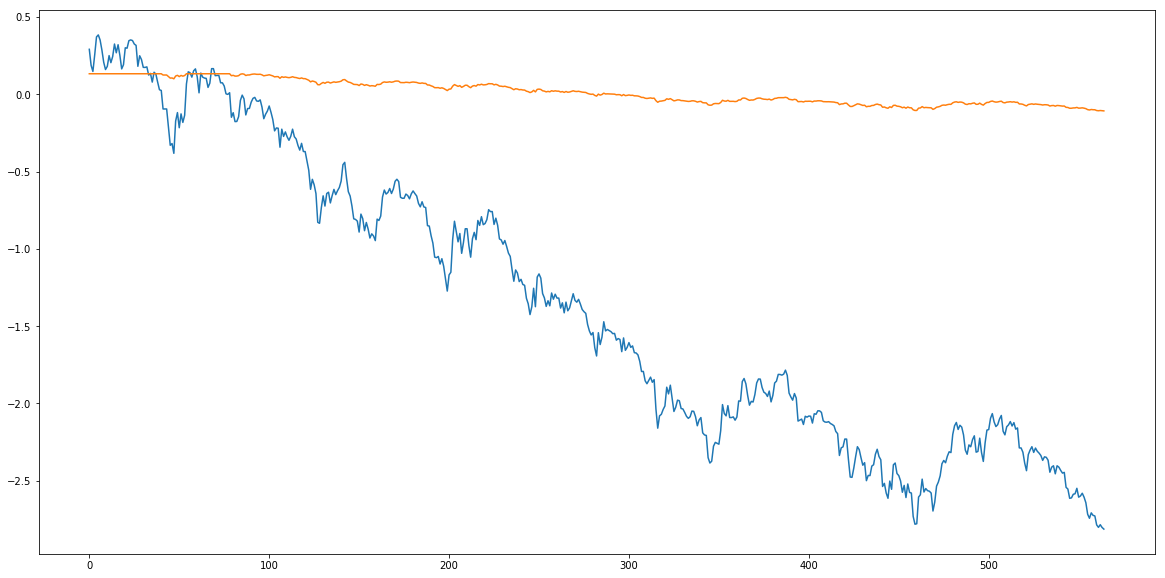

In [39]:
y_pred = model.predict(y_test)
plt.plot(y_test)
plt.plot(y_pred)
print('R-Squared: %f'%(r2_score(y_test, y_pred)))
plt.show()